# Arrays

<img src="images/array.png" width="25%" align="right">
Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

In this notebook, we'll build some understanding by implementing some blocked algorithms from scratch.
We'll then use Dask Array to analyze large datasets, in parallel, using a familiar NumPy-like API.

**Related Documentation**

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

## Create data

In [1]:
import h5py
import os
import numpy as np

In [2]:
def random_data(fn = 'random.hdf5'):
    blocksize = 1000000
    nblocks = 1000
    shape = nblocks * blocksize
    if os.path.exists(fn):
        return

    with h5py.File(fn, mode='w') as f:
        dset = f.create_dataset('/x', shape=(shape,), dtype='f4')
        for i in range(0, shape, blocksize):
            dset[i: i + blocksize] = np.random.exponential(size=blocksize)

## Read data

In [3]:
fn = "random.hdf5"
random_data(fn)

## Setup DASK Client

In [4]:
from dask.distributed import Client
client = Client(n_workers=4)

C:\Users\jem\Anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52044 instead
  warnings.warn(


## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

We do exactly this with Python and NumPy in the following example:

In [7]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
f = h5py.File('random.hdf5', mode='r')
dset = f['/x']
dset.shape

(1000000000,)

In [8]:
dset[:10]

array([0.01567074, 2.6447656 , 0.2722521 , 2.9990795 , 0.15437327,
       1.38482   , 0.13298438, 2.2614825 , 0.0236893 , 1.0147603 ],
      dtype=float32)

**Compute sum using blocked algorithm**

Before using dask, let's consider the concept of blocked algorithms. We can compute the sum of a large number of elements by loading them chunk-by-chunk, and keeping a running total.

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums

Note that this is a sequential process in the notebook kernel, both the loading and summing.

In [9]:
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

999966640.0625


Now that we've seen the simple example above, try doing a slightly more complicated problem. Compute the mean of the array, assuming for a moment that we don't happen to already know how many elements are in the data.  You can do this by changing the code above with the following alterations:

1.  Compute the sum of each block
2.  Compute the length of each block
3.  Compute the sum of the 1,000 intermediate sums and the sum of the 1,000 intermediate lengths and divide one by the other

This approach is overkill for our case but does nicely generalize if we don't know the size of the array or individual blocks beforehand.

In [ ]:
sums = []
lengths = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

0.9999666400625


`dask.array` contains these algorithms
--------------------------------------------

Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory.  It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

**Create `dask.array` object**

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1_000_000,)`

In [ ]:
import dask.array as da
x = da.from_array(dset, chunks=(1_000_000,))
x

dask.array<array, shape=(1000000000,), dtype=float32, chunksize=(1000000,), chunktype=numpy.ndarray>

**Manipulate `dask.array` object as you would a numpy array**

Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

**What's the difference?**

`dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.

*Why the difference?*

Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [ ]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

**Compute result**

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [ ]:
result.compute()

999966600.0

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.307227 to fit


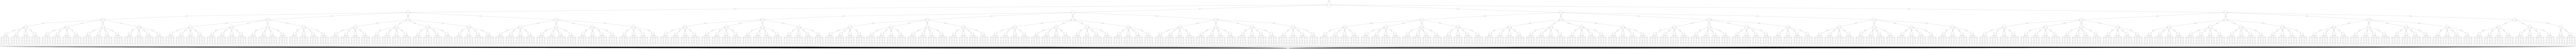

In [ ]:
result.visualize()

### Exercise:  Compute the mean

And the variance, std, etc..  This should be a small change to the example above.

Look at what other operations you can do with the Jupyter notebook's tab-completion.

Does this match your result from before?

Performance and Parallelism
-------------------------------

<img src="images/fail-case.gif" width="40%" align="right">

In our first examples we used `for` loops to walk through the array one block at a time.  For simple operations like `sum` this is optimal.  However for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

`Dask.array` translates your array operations into a graph of inter-related tasks with data dependencies between them.  Dask then executes this graph in parallel with multiple threads.  We'll discuss more about this in the next section.



### Example

1.  Construct a 20000x20000 array of normally distributed random values broken up into 1000x1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [ ]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [ ]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [ ]:
%%time
y.compute()     # Time to compute the result

Wall time: 7.76 s


array([ 9.99976019,  9.99924024, 10.0007796 ,  9.99924859, 10.00022844,
        9.99965849,  9.99933781, 10.0004988 , 10.00027263, 10.00017988,
        9.99969855, 10.001025  ,  9.9995149 ,  9.99883826, 10.00002287,
        9.99891563,  9.9986728 , 10.00105408, 10.00067902, 10.00016547,
        9.9988525 , 10.00009366, 10.00018114, 10.00012879, 10.00103723,
       10.0004669 , 10.00100786, 10.00083132,  9.99928569, 10.00061107,
       10.00099579,  9.99979553, 10.00053819,  9.99967708, 10.00004497,
        9.99993985,  9.99971845, 10.00038666,  9.9996863 , 10.00001072,
        9.99912684,  9.99876965,  9.99947118, 10.00002444, 10.00010955,
        9.99924937, 10.00046299, 10.00020516, 10.00090026,  9.99962741,
        9.99903864,  9.99911901, 10.00035147,  9.9998782 , 10.00025606,
        9.9998628 ,  9.99963095, 10.00008094,  9.99995927, 10.00092812,
       10.00013256,  9.99983066, 10.00110153, 10.00130646, 10.00100915,
        9.99961328, 10.00170188, 10.00089802,  9.99974108, 10.00

Performance comparison
---------------------------

The following experiment was performed on a heavy personal laptop.  Your performance may vary.  If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

**NumPy: 19s, Needs gigabytes of memory**

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

**Dask Array: 4s, Needs megabytes of memory**

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

**Discussion**

Notice that the Dask array computation ran in 4 seconds, but used 29.4 seconds of user CPU time. The numpy computation ran in 19.7 seconds and used 19.6 seconds of user CPU time.

Dask finished faster, but used more total CPU time because Dask was able to transparently parallelize the computation because of the chunk size.

*Questions*

*  What happens if the dask chunks=(20000,20000)?
    * Will the computation run in 4 seconds?
    * How much memory will be used?
* What happens if the dask chunks=(25,25)?
    * What happens to CPU and memory?

In [ ]:
client.close()